### Análisis Realizado

Al analizar los documentos, se buscan responder las siguientes preguntas:

1) <b> ¿Cuales son los temas mas relevantes que se expusieron en los medios duante 2017 sobre la temática violencia? </b>

2) <b> ¿De qué temas relacionados a la violencia hablan los 5 medios con más noticias en Chile? </b>

Para esto, se realiza el siguiente analisis:

1) Se analizan distribuciones por fecha de noticias y por cantidad de noticias por cada medio, con la intención de encontrar los 5 medios con más noticias.

2) Se implementa modelo de clustering K-means, analizando los tópicos encontrados.

3) Se implementa modelo LDA utilizando Inferencia Bayesiana, analizando los tópicos encontrados.

4) Tomando como modelo el LDA Bayesiano, se responden preguntas de investigación planteadas:

    a) Se identifican tópicos identificados en los documentos para el año 2017.
    b) Se identifica la distribución de tópicos para cada uno de los 5 medios escogidos, analizando su distribución.
    
5) Se implementa modelo LDA utilizando Gibbs Sampling, analizando los tópicos encontrados.

6) Comparación resultados obtenidos por modelos

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
#%matplotlib notebook


### Importar datos

In [29]:
# Get data

# Import data

# file name
file = 'MAD_violencia1.csv'

# load data
df = pd.read_csv(file, sep = '|', error_bad_lines = False, header = None)

# Parse to datetime format
df[0] = pd.to_datetime(df[0])

display(df.head())

# Get date and news text
news = df[[0,1,3]]

# Shape of dataframe
display('Total news: ' + str(news.shape[0]))

# Columns
news.columns = ['date', 'company', 'news']

# text
# news = news[0:100]
# n = 10
# n = 100
# n = 1500 # tooooo slow
#n = 1000 # too slow
#n = 500 # good in velocity, bad in clustering with LDA
#n = 700 # bad in velocity, bad in clustering with LDA
#news = news.sample(n)

news.head()

,0,1,2,3
0,2017-05-23 10:40:09,lacuarta,¡Sea solidario y póngase con las mamitas de C...,Esto te interesa... 22/05/2017 - Autor: La Cu...
1,2017-05-18 12:59:58,RadioValparaiso,Radio Valparaíso PDI DETIENE A AUTOR DE ROBO ...,Portada » CIUDADES » Valparaíso » PDI DETIENE...
2,2017-06-01 22:40:30,araucanianews,SOFO y SNA cuestionaron cuenta pública de Bac...,"Jueves, 1 Junio, 2017 a las 22:39 Editor Actu..."
3,2017-06-01 08:20:07,chilevision,Detuvieron a hombre que intentó asesinar a su...,La Policía de Investigaciones detuvo a un hom...
4,2017-06-01 19:10:00,PublimetroChile,Feminicidio en Argentina: mujeres se desnudan...,La Fuerza Artística de Choque Comunicativo or...


'Total news: 4468'

,date,company,news
0,2017-05-23 10:40:09,lacuarta,Esto te interesa... 22/05/2017 - Autor: La Cu...
1,2017-05-18 12:59:58,RadioValparaiso,Portada » CIUDADES » Valparaíso » PDI DETIENE...
2,2017-06-01 22:40:30,araucanianews,"Jueves, 1 Junio, 2017 a las 22:39 Editor Actu..."
3,2017-06-01 08:20:07,chilevision,La Policía de Investigaciones detuvo a un hom...
4,2017-06-01 19:10:00,PublimetroChile,La Fuerza Artística de Choque Comunicativo or...


### Analizado data por fecha y por medio

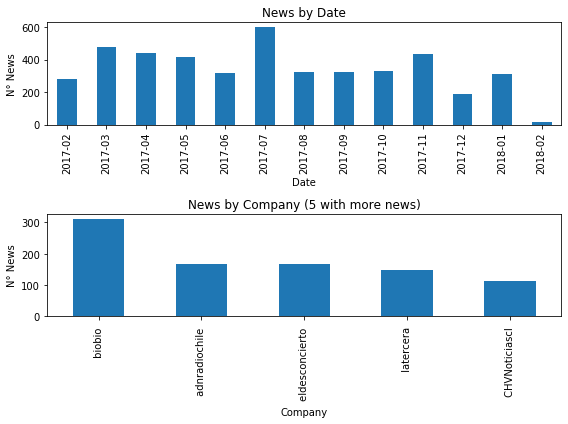

In [30]:
# Analize news by date
news_grouped_by_month = news.groupby(news.date.dt.to_period("M")).count()
news_per_month = news_grouped_by_month.news

#display(news_per_month)
fig1, axes = plt.subplots(2,1, figsize = (8,6))

ax1 = news_per_month.plot.bar(ax = axes[0], x = 'date', y = 'news')
ax1.set_xlabel("Date")
ax1.set_ylabel('N° News')
ax1.title.set_text('News by Date')
plt.tight_layout()

# Analize news by company
news_grouped_by_company = news.groupby(news.company).count()
#print(news_grouped_by_company.sort(['news']))

# Sort by number of news
news_grouped_by_company.sort_values(['date'], ascending=False, inplace = True)

top_companies = 5

news_per_company = news_grouped_by_company.news[0:top_companies]

top_20_companies = news_per_company.index

ax2 = news_per_company.plot.bar(ax = axes[1], x = 'company', y = 'News')
ax2.set_xlabel("Company")
ax2.set_ylabel('N° News')
ax2.title.set_text('News by Company (5 with more news)')
plt.tight_layout()

Del gráfico de noticias en función de la fecha, se tiene que para Julio existe un máximo número de noticias (Otra posible arista de exploración es analizar que sucede en esa fecha, probablemente haya ocurrido algún evento mediático).

Del gráfico de las noticias en función de la compañia, se tiene que el medio Bío Bío es quien posee más número de noticias de violencia comparado con los demás medios.

### Tokenizer

In [31]:
# Tokenizador

# Define own tokenizer
#import spacy

nlp = spacy.load('es_core_news_sm')

def own_tokenizer(sentence):
    
    tokens = []
    
    doc = nlp(sentence.lower().strip())
    
    for token in doc:
        
        # Filtering
        if not token.is_space and not token.is_stop and not token.is_punct and not token.is_digit and not token.like_num:
            
            # add token to list in lemma form
            tokens.append(token.lemma_)
            
    return tokens

In [32]:
# Stop words (not has information)
stop_words = ['a','e','i','o','u',' ','  ','   ','  ','$','  ','y', '-', 'c', 'nna', 'e', 'l', '=', '<', '>','x','href','/']

### Representación vectorial utilizando TFIDF Vectorizer

In [33]:
# Vectorizator
tfid_vectorizer = TfidfVectorizer(tokenizer = own_tokenizer, stop_words = stop_words, ngram_range = (1,1))

news_vector_tfidf = tfid_vectorizer.fit_transform(news['news'])

# Get features names
news_vector_features = tfid_vectorizer.get_feature_names()

/home/leo/Desktop/master_UACH/env/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['litro'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Se utiliza TF-IDF debido a mejor representación de documentos, ya que permite identificar palabras claves que permiten diferenciar claramente de los otros documentos.

### Clustering utilizando K-means

In [34]:
# Find optimal value of n° of clusters

# Training model

#from sklearn.cluster import KMeans

# Number of clusters
num_k = range(1,10)

# Inertia list
inertia = []

# Iter over each k value
for i in num_k:
    
    print('Iter: {0}'.format(i))
    
    # Set model
    model = KMeans(n_clusters = i, n_init=5)
    
    # Fit model
    model.fit(news_vector_tfidf)
    
    # add intertia of model
    inertia.append(model.inertia_)

Iter: 1
Iter: 2
Iter: 3
Iter: 4
Iter: 5
Iter: 6
Iter: 7
Iter: 8
Iter: 9


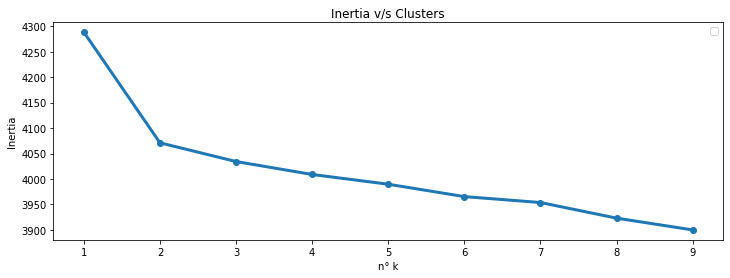

In [35]:
# plot inertia values

#import matplotlib.pyplot as plt

f, (ax) = plt.subplots(figsize = (12,4))
ax.plot(num_k, inertia, '-o', linewidth = 3)
ax.set_xlabel('n° k')
ax.set_ylabel('Inertia')
ax.title.set_text('Inertia v/s Clusters')
ax.legend()

Observando el gráfico, se tienen varios valores en donde la tasa de disminución disminuye, en donde el menor valor corresponde a 2, sin embargo, considerando el volumen de documentos, agrupar en sólo 2 cluster no sería óptimo, por lo que se definen 5 de clusters, ya que es el siguiente valor en donde se produce una disminución de la tasa de disminución.

In [9]:
# N° of clusters
k_k_means = 5

In [10]:
# Train model

# Set model
model = KMeans(n_clusters = k_k_means, init = 'k-means++', max_iter = 10, n_init = 10)

# Fit model
model.fit(news_vector_tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Top Words per Topic: 

centroid 0: 
 
 mujer  ,  violencia  ,  denunciar  ,  género  ,  año  ,  chile  ,  derecho  ,  víctima  ,  casar  ,  condenar  ,  país  ,  parejo  ,  social  ,  tipo  ,  sexual 

centroid 1: 
 
 ciudad  ,  newsletter  ,  recibir  ,  correo  ,  guioteca  ,  soychile.cl  ,  farox  ,  inmobiliario  ,  entérate  ,  contáctenos  ,  hoyxhoy.cl  ,  suscríbete  ,  futuro  ,  emol  ,  propiedad 

centroid 2: 
 
 loading  ,  working  ,  playlists  ,  natural  ,  acontecimiento  ,  postal  ,  desastre  ,  selección  ,  meteorológico  ,  seminario  ,  https://www.facebook.com/girovisualtv  ,  https://twitter.com/girovisualtv  ,  golf  ,  http://www.girovisual.cl  ,  captar 

centroid 3: 
 
 mujer  ,  rincón  ,  violencia  ,  intrafamiliar  ,  diputar  ,  carolina  ,  comuna  ,  goic  ,  candidatura  ,  dc  ,  ley  ,  ricardo  ,  chilevisión  ,  partir  ,  medir 

centroid 4: 
 
 robar  ,  violencia  ,  detener  ,  registrar  ,  policial  ,  sustraer  ,  región  ,  policía  ,

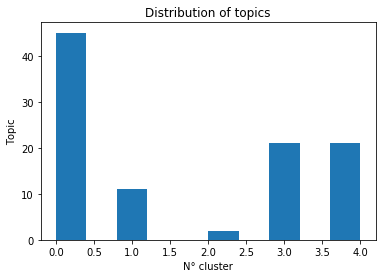

In [11]:
# Display top words

# Get order centroids
order_centroids = model.cluster_centers_.argsort()[:,::-1]

n_top_words = 15

print('Top Words per Topic: \n')

# Get principal words of each centroid
for i in range(0,k_k_means):
    
    centroid_words = np.array(news_vector_features)[order_centroids[i, 0:n_top_words]]
    
    print('centroid {0}: \n \n {1} \n'.format(i, '  ,  '.join(centroid_words)))

# Ploting results
labels = model.predict(news_vector_tfidf)

fig, ax = plt.subplots()

# TFIDF
#ax.scatter(range(labels.shape[0]),labels,c=labels)
ax.hist(labels)
ax.set_ylabel('Topic')
ax.set_xlabel('N° cluster')
ax.title.set_text('Distribution of topics')

Desde los tops words obtenidos por cada cluster, se puede inferir los siguientes tópicos asociados a cada cluster:

- Tópico 0: Llamado a suscripción al medio
- Tópico 1: Violencia contra la mujer
- Tópico 2: Episodio de violencia de vocalista de grupo "Los Tetas"
- Tópico 3: Llamado a suscripción al medio
- Tópico 4: Violencia deportiva en estadios

Además, desde el gráfico de distribución de tópicos se tiene que la gran mayoría de las noticias corresponden a "Violencia contra la mujer".


### Representación vectorial de documentos utilizando Count Vectorizer

In [12]:
# Vectorizacion de textos usando Count vectorizer

# from sklearn.feature_extraction.text import CountVectorizer
# Vector representation of news
count_vectorizer = CountVectorizer(tokenizer = own_tokenizer, stop_words = stop_words, ngram_range = (1,1))

# Count vectorizer
news_vector_count = count_vectorizer.fit_transform(news['news'])

# Get features names
news_vector_features = count_vectorizer.get_feature_names()

/home/leo/Desktop/master_UACH/env/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['litro'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


### Implementación modelo LDA utilizando Inferencia Variacional 

Topic number 1 

Topic number 2 

Topic number 3 

Topic number 4 

Topic number 5 

Topic number 6 

Topic number 7 

Topic number 8 

Topic number 9 



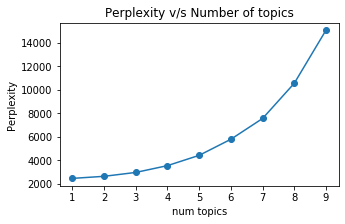

In [13]:
# find optimal number of topics

#from sklearn.decomposition import LatentDirichletAllocation
#import matplotlib.pyplot as plt

# Perplexity list
perp = []

# number of topics
num_topic = range(1,10)

# Iter over each value of topic
for topic in num_topic:
    
    print('Topic number {0} \n'.format(topic))
    
    # Define lda model
    lda = LatentDirichletAllocation(n_components = topic, max_iter = 10,
      learning_method = 'online',
      learning_offset = 50,
      random_state = 0)
    
    # Fit model
    lda.fit(news_vector_count)
    
    # add perplexity
    perp.append(lda.perplexity(news_vector_count))
    
# Plot all k values
fig2, ax = plt.subplots(figsize = (5,3))
ax.plot(num_topic, perp, '-o')
ax.set_xlabel('num topics')
ax.set_ylabel('Perplexity')
ax.title.set_text('Perplexity v/s Number of topics')

Del gráfico se tiene que se definen 7 topicos, ya que para el 8 se observa aumento mayor en tasa de crecimiento de perplexity.

In [14]:
# Define topics
topics = 7

Model fitted



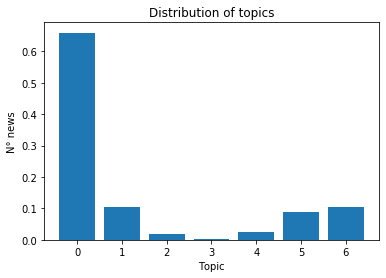

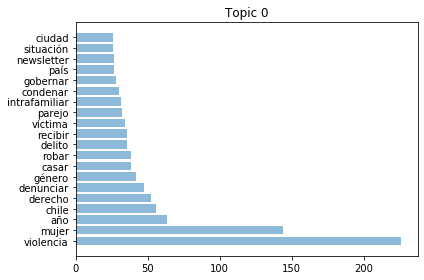

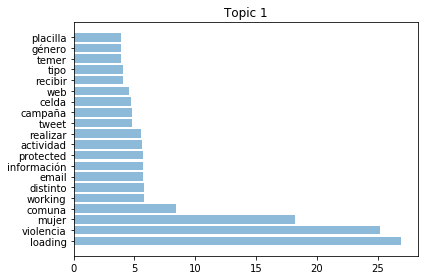

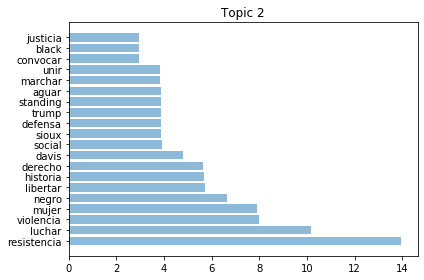

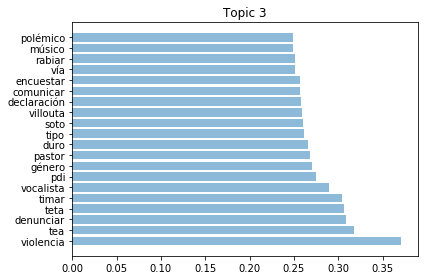

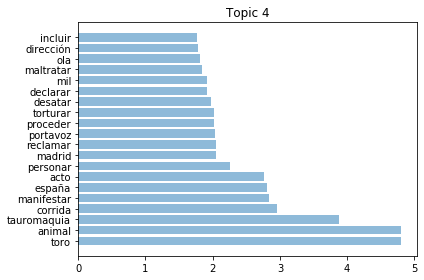

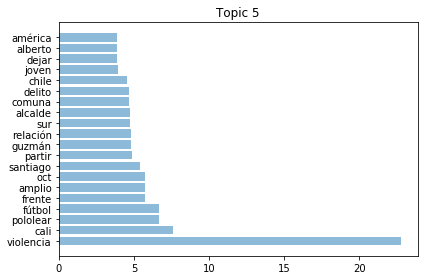

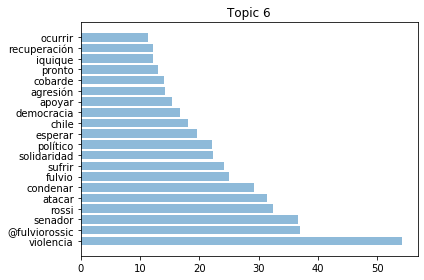

In [15]:
# Training defined model 
#Generando algunos gráficos de los resultados

lda = LatentDirichletAllocation(n_components=topics, max_iter=50,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

# (100, 7)
topic_distribution_per_documents = lda.fit_transform(news_vector_count)

print('Model fitted\n')

#distribución de tópicos en todos los documentos
dist_per_topic = sum(topic_distribution_per_documents)/len(news.news)

topics_array = np.arange(0,topics)

#plotting disttribution
fig, ax = plt.subplots()
ax.bar(topics_array, dist_per_topic)
ax.set_xlabel('Topic')
ax.set_ylabel('N° news')
ax.title.set_text('Distribution of topics')

#distribución de tópicos en el documento 100
#plt.bar(topics_array,height=dist_per_topic,alpha=0.5,tick_label=topics_array)
#show()

#print(lda.components_.shape)
#frecuencia de palabras por tópico
n_top_words=20
numo =np.arange(0,n_top_words)
for idx,topic in enumerate(lda.components_):
    d =[]
    s = []
    for i in topic.argsort()[:-n_top_words - 1:-1]:
          s.append(news_vector_features[i])
          d.append(topic[i])
    plt.figure()
    plt.barh(numo,width=d,alpha=0.5,tick_label=s)
    plt.title('Topic ' + str(idx))
    plt.tight_layout()
    plt.show()


#### Respuesta a pregunta de investigación:

##### ¿Cuales son los temas mas relevantes que se expusieron en los medios durante 2017 sobre la temática violencia?

De las top-words de cada tópico, se logra indentificar los siguientes temas:

- Topic 0: Juicio legal asociados a Violencia
- Topic 1: Donald Trump - Asesinato en marcha en USA (Las Vegas).
- Topic 2: Violencia contra la mujer.
- Topic 3: Suscripción al medio.
- Topic 4: Crimen en estadio fubtol.
- Topic 5: Violencia Machismo.
- Topic 6: Violencia y Mapuches.

Desde el gráfico de distribución de tópicos, se tiene que los mayores temas desarrollados por los medios corresponden a:

1) Violencia contra la mujer.

2) Suscripción al medio.

3) Violencia y Mapuches

Se destaca que el tema "Suscripción al medio" no corresponde a un tema asociado a violencia, sin embargo se mantiene en el análisis debido a que demuestran el interés de los medios por lograr nuevos suscriptores através del uso de noticias de violencia.

### Respuesta a pregunta de Investigación

##### ¿De qué temas relacionados a la violencia hablan los 5 medios con más noticias en Chile?

In [16]:
# Name to topic
topic_name = ['Juicio legal asociados a violencia',
             'Asesinato marcha en USA',
              'Violencia contra la mujer',
              'Suscripción al medio',
              'Crimen en estadio fubtol',
              'Violencia Machismo',
              'Violencia y Mapuches',
             ]

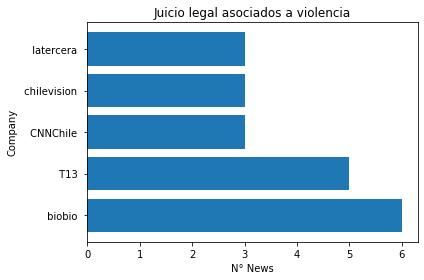

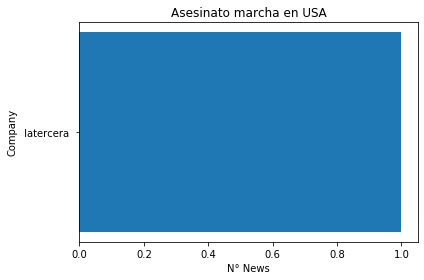

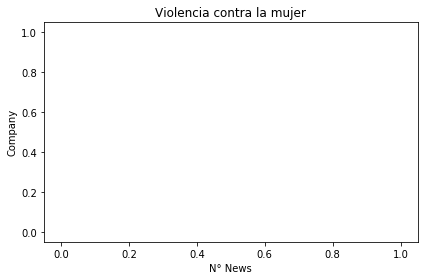

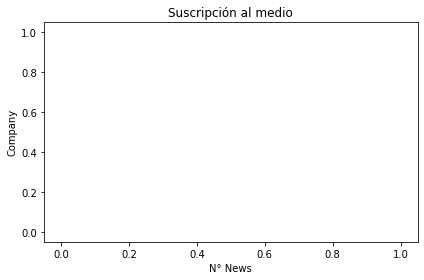

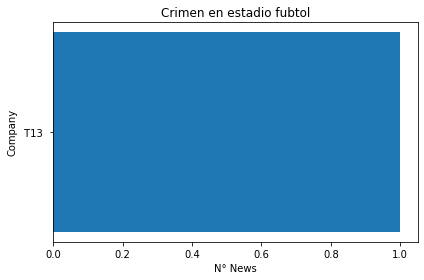

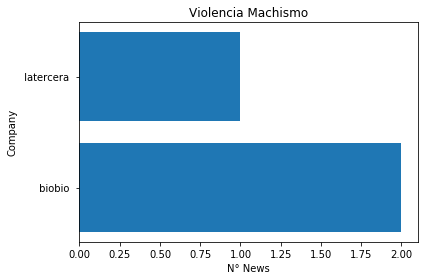

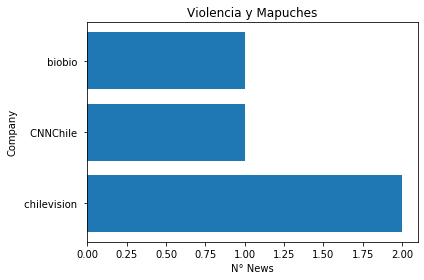

In [17]:
# Assign to each document the most frecuent topic
z=[]
for i in range(len(news.news)):
    z.append(np.argmax(topic_distribution_per_documents[i]))

# add a new variable to dataframe
news['topic'] = z

# iterate over each topic
for topic_num in range(0,topics):
    
    companies_per_topic = news[(news['company'].isin(top_20_companies)) & (news['topic'] == topic_num)].groupby('company').count().sort_values(['news'], ascending=False)
    plt.figure()
    plt.barh(y = companies_per_topic.index.values, width = companies_per_topic.news)
    plt.xlabel('N° News')
    plt.ylabel('Company')
    plt.title(str(topic_name[topic_num]))
    plt.tight_layout()


De los gráficos se observa que los medios que más hablan por cada tópico corresponden a:

- Asesinato marcha en USA: La Tercera.
- Violencia contra la mujer: BioBio, El Desconcierto, ADN Radio, La Tercera,
- Suscripción al medio: El Mercurio.
- Crimen Estadio de Fubtol: ADN Radio.

Cabe destacar que existen gráficos sin datos ya que se tomaron solamente los 5 medios con más noticias, por lo que otros medios sean quienes tengan asociados esos tópicos.

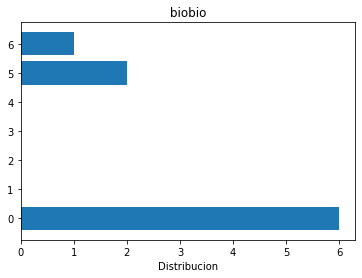

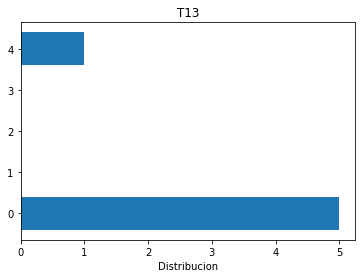

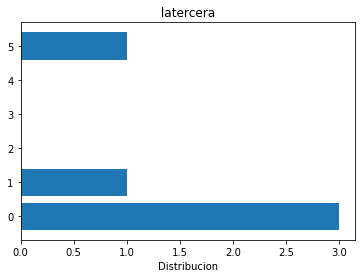

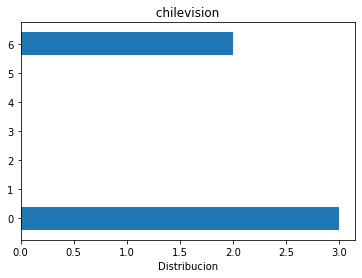

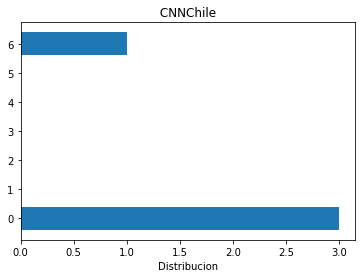

In [18]:
# Print distribution per medium

# for idx, medium in top_20_companies:
for num, medium in enumerate(top_20_companies):
    
    asd = news[(news['company'].isin(top_20_companies)) & (news.company == medium)].groupby('topic').count()
    
    plt.figure()
    
    plt.barh(y = asd.index.values, width = asd.news)
    
    plt.xlabel('Distribucion')
    
    plt.title(medium)

De los gráficos se observa que cada medio habla principalmente de los siguientes temas:

- Bio Bio: Violencia contra la mujer.
- El Desconcierto: Violencia contra la mujer.
- Mercurio Valpo: Suscripción.
- ADN Radio: Crimen Estadio de Futbol, Violencia contra la mujer.
- La Tercera: Violencia contra la mujer, Asesinato en USA (Las Vegas).

### Implementación modelo LDA utilizando Gibbs Sampling

In [19]:
import lda

model = lda.LDA(n_topics = topics, n_iter=10000, alpha=0.1, eta=0.1, random_state=3)
model.fit(news_vector_count)  # model.fit_transform(X) is also available

topic_word = model.topic_word_  # model.components_ also works

n_top_words=10

for i, topic_dist in enumerate(topic_word):
    
    topic_words = np.array(news_vector_features)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

INFO:lda:n_documents: 100
INFO:lda:vocab_size: 3763
INFO:lda:n_words: 13455
INFO:lda:n_topics: 7
INFO:lda:n_iter: 10000
/home/leo/Desktop/master_UACH/env/lib/python3.6/site-packages/lda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):
INFO:lda:<0> log likelihood: -138733
INFO:lda:<10> log likelihood: -113785
INFO:lda:<20> log likelihood: -109992
INFO:lda:<30> log likelihood: -109202
INFO:lda:<40> log likelihood: -108720
INFO:lda:<50> log likelihood: -108781
INFO:lda:<60> log likelihood: -108715
INFO:lda:<70> log likelihood: -108961
INFO:lda:<80> log likelihood: -108634
INFO:lda:<90> log likelihood: -108770
INFO:lda:<100> log likelihood: -108773
INFO:lda:<110> log likelihood: -108758
INFO:lda:<120> log likelihood: -108874
INFO:lda:<130> log likelihood: -108697
INFO:lda:<140> log likelihood: -

INFO:lda:<1970> log likelihood: -108430
INFO:lda:<1980> log likelihood: -108478
INFO:lda:<1990> log likelihood: -108589
INFO:lda:<2000> log likelihood: -108493
INFO:lda:<2010> log likelihood: -108625
INFO:lda:<2020> log likelihood: -108836
INFO:lda:<2030> log likelihood: -108605
INFO:lda:<2040> log likelihood: -108560
INFO:lda:<2050> log likelihood: -108358
INFO:lda:<2060> log likelihood: -108538
INFO:lda:<2070> log likelihood: -108640
INFO:lda:<2080> log likelihood: -108356
INFO:lda:<2090> log likelihood: -108536
INFO:lda:<2100> log likelihood: -108459
INFO:lda:<2110> log likelihood: -108510
INFO:lda:<2120> log likelihood: -108624
INFO:lda:<2130> log likelihood: -108623
INFO:lda:<2140> log likelihood: -108612
INFO:lda:<2150> log likelihood: -108767
INFO:lda:<2160> log likelihood: -108626
INFO:lda:<2170> log likelihood: -108736
INFO:lda:<2180> log likelihood: -108641
INFO:lda:<2190> log likelihood: -108661
INFO:lda:<2200> log likelihood: -108683
INFO:lda:<2210> log likelihood: -108390


INFO:lda:<4020> log likelihood: -108563
INFO:lda:<4030> log likelihood: -108561
INFO:lda:<4040> log likelihood: -108477
INFO:lda:<4050> log likelihood: -108591
INFO:lda:<4060> log likelihood: -108501
INFO:lda:<4070> log likelihood: -108666
INFO:lda:<4080> log likelihood: -108686
INFO:lda:<4090> log likelihood: -108666
INFO:lda:<4100> log likelihood: -108704
INFO:lda:<4110> log likelihood: -108688
INFO:lda:<4120> log likelihood: -108583
INFO:lda:<4130> log likelihood: -108475
INFO:lda:<4140> log likelihood: -108411
INFO:lda:<4150> log likelihood: -108766
INFO:lda:<4160> log likelihood: -108584
INFO:lda:<4170> log likelihood: -108447
INFO:lda:<4180> log likelihood: -108483
INFO:lda:<4190> log likelihood: -108422
INFO:lda:<4200> log likelihood: -108537
INFO:lda:<4210> log likelihood: -108498
INFO:lda:<4220> log likelihood: -108431
INFO:lda:<4230> log likelihood: -108686
INFO:lda:<4240> log likelihood: -108724
INFO:lda:<4250> log likelihood: -108441
INFO:lda:<4260> log likelihood: -108554


INFO:lda:<6070> log likelihood: -108530
INFO:lda:<6080> log likelihood: -108452
INFO:lda:<6090> log likelihood: -108661
INFO:lda:<6100> log likelihood: -108598
INFO:lda:<6110> log likelihood: -108452
INFO:lda:<6120> log likelihood: -108670
INFO:lda:<6130> log likelihood: -108527
INFO:lda:<6140> log likelihood: -108414
INFO:lda:<6150> log likelihood: -108904
INFO:lda:<6160> log likelihood: -108744
INFO:lda:<6170> log likelihood: -108696
INFO:lda:<6180> log likelihood: -108616
INFO:lda:<6190> log likelihood: -108527
INFO:lda:<6200> log likelihood: -108541
INFO:lda:<6210> log likelihood: -108407
INFO:lda:<6220> log likelihood: -108538
INFO:lda:<6230> log likelihood: -108576
INFO:lda:<6240> log likelihood: -108247
INFO:lda:<6250> log likelihood: -108637
INFO:lda:<6260> log likelihood: -108525
INFO:lda:<6270> log likelihood: -108456
INFO:lda:<6280> log likelihood: -108460
INFO:lda:<6290> log likelihood: -108740
INFO:lda:<6300> log likelihood: -108637
INFO:lda:<6310> log likelihood: -108530


INFO:lda:<8120> log likelihood: -108531
INFO:lda:<8130> log likelihood: -108604
INFO:lda:<8140> log likelihood: -108419
INFO:lda:<8150> log likelihood: -108193
INFO:lda:<8160> log likelihood: -108626
INFO:lda:<8170> log likelihood: -108492
INFO:lda:<8180> log likelihood: -108631
INFO:lda:<8190> log likelihood: -108241
INFO:lda:<8200> log likelihood: -108087
INFO:lda:<8210> log likelihood: -108375
INFO:lda:<8220> log likelihood: -108462
INFO:lda:<8230> log likelihood: -108625
INFO:lda:<8240> log likelihood: -108353
INFO:lda:<8250> log likelihood: -108300
INFO:lda:<8260> log likelihood: -108445
INFO:lda:<8270> log likelihood: -108683
INFO:lda:<8280> log likelihood: -108600
INFO:lda:<8290> log likelihood: -108571
INFO:lda:<8300> log likelihood: -108743
INFO:lda:<8310> log likelihood: -108624
INFO:lda:<8320> log likelihood: -108497
INFO:lda:<8330> log likelihood: -108567
INFO:lda:<8340> log likelihood: -108570
INFO:lda:<8350> log likelihood: -108390
INFO:lda:<8360> log likelihood: -108529


Topic 0: violencia derecho víctima niño mujer salud embarazar atención medir sexual
Topic 1: violencia año casar delito hecho tipo carabinero mujer condenar policial
Topic 2: violencia ley gobernar rincón diputar valparaíso intrafamiliar delito leer agostar
Topic 3: loading trump resistencia violencia político video unir luchar frente dejar
Topic 4: violencia senador @fulviorossic atacar rossi condenar fulvio solidaridad esperar político
Topic 5: mujer violencia chile género derecho país denunciar reservar parejo social
Topic 6: violencia recibir ciudad sitiar newsletter chile mundo teta anunciar denunciar


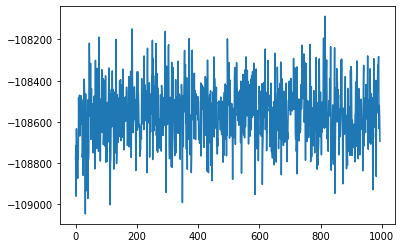

In [20]:
plt.plot(model.loglikelihoods_[5:])

El algoritmo converge ya que se mantiene pendiente constante para valores superiores a 500.

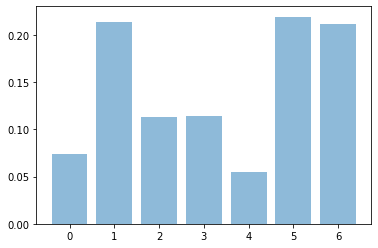

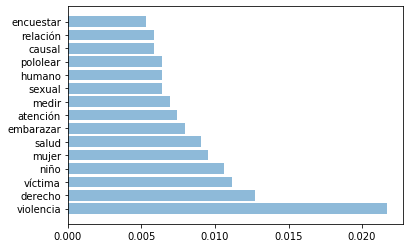

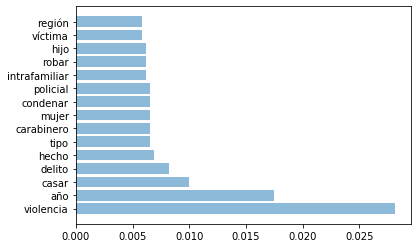

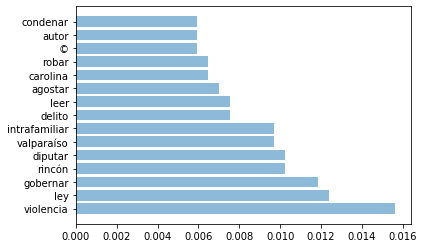

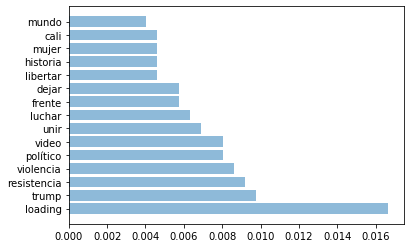

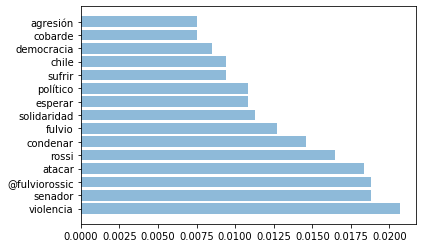

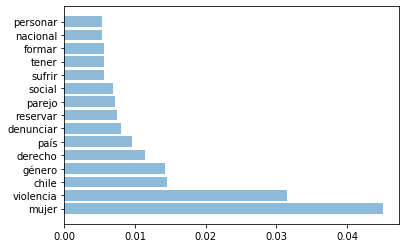

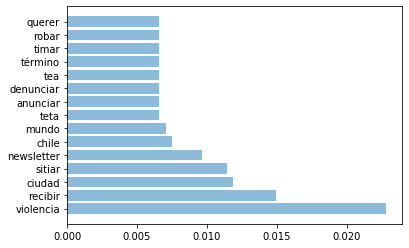

In [21]:
#Generando algunos gráficos de los resultados
#from matplotlib.pylab import hist, show

y = model.doc_topic_
#distribución de tópicos en todos los documentos
dist = sum(y)/len(news.news)

w=np.arange(0,topics)

plt.bar(w,height=dist,alpha=0.5,tick_label=w)

plt.show()

#frecuencia de palabras por tópico
n_top_words=15
numo =np.arange(0,n_top_words)

for idx,topic in enumerate(model.topic_word_):
    d =[]
    s = []
    for i in topic.argsort()[:-n_top_words - 1:-1]:
          s.append(news_vector_features[i])
          d.append(topic[i])
    
    plt.barh(numo,width=d,alpha=0.5,tick_label=s)
    plt.show()



De los gráficos de topwords, se infieren los siguientes tópicos:

- Topico 0: Violencia y Mapuches.
- Tópico 1: Violencia contra la mujer.
- Tópico 2: Suscripcioń al medio.
- Tópico 3: Episodio de violencia de vocalista de grupo "Los Tetas"
- Tópico 4: Violencia y Política.
- Tópico 5: Violencia Escolar.
- Tópico 6: Violencia Intrafamiliar.

Respecto a la distribución de tópicos en los documentos, se tiene que los mayores temas  corresponden a:

1) Violencia Intrafamiliar.

2) Suscripción.

3) Violencia y Política.

### Comparación resultados obtenidos por modelos

Respecto al número de clusters se tiene:

- K-means: 5 tópicos.
- LDA Bayesian: 7 tópicos.
- LDA Gibbs: 7 tópicos.

Por lo tanto, según los diferentes métodos, cada algoritmo logra identificar diferentes números de tópicos en las noticias.

Con respecto a los temas identificados por tópicos, se tiene lo siguiente:

- K-means:
    
    - Tópico 0: Llamado a suscripción al medio
    - Tópico 1: Violencia contra la mujer
    - Tópico 2: Episodio de violencia de vocalista de grupo "Los Tetas"
    - Tópico 3: Llamado a suscripción al medio
    - Tópico 4: Violencia deportiva en estadios
    
    
- LDA Bayesian:
    - Topic 0: Juicio legal asociados a Violencia
    - Topic 1: Donald Trump - Asesinato en marcha en USA (Las Vegas).
    - Topic 2: Violencia contra la mujer.
    - Topic 3: Suscripción al medio.
    - Topic 4: Crimen en estadio fubtol.
    - Topic 5: Violencia Machismo.
    - Topic 6: Violencia y Mapuches.
    
    
- LDA Gibbs:

    - Topico 0: Violencia y Mapuches.
    - Tópico 1: Violencia contra la mujer.
    - Tópico 2: Suscripcioń al medio.
    - Tópico 3: Episodio de violencia de vocalista de grupo "Los Tetas"
    - Tópico 4: Violencia y Política.
    - Tópico 5: Violencia Escolar.
    - Tópico 6: Violencia Intrafamiliar.

Existen varios temas que se repiten, tales como la "Suscripcion", "Violencia contra la mujer", Episodio de violencia de vocalista de grupo "Los Tetas" (sólo en K-means y LDA Gibbs), "Violencia deportiva en estadios" (solo en K-means y LDA bayesian), y "Violencia y Mapuches" (solo en LDA's). Por lo tanto, dada la similaridad de temas identificados, se concluye que existe semejanza entre los resultados obtenidos.

Cabe destacar que para propósitos de esta investigación, se asigna un tópico a cada documento, no considerando la distribución entregada por LDA, la cual es una ventaja sobre K-means y la cual es útil para otras implementaciones.

Respecto a la pregunta de investigación sobre que temas se hablaron en los medios para el 2017, se tiene lo siguiente:

- K-means: 

    1) Violencia contra la mujer.
    
    
- LDA Bayesian: 

    1) Violencia contra la mujer.

    2) Suscripción al medio.

    3) Violencia y Mapuches
    
    
- LDA Gibbs:

    1) Violencia Intrafamiliar.

    2) Suscripción.

    3) Violencia y Política.
    
De los cuales, se tiene que para los 2 primeros modelos, el tema principal corresponde a "Violencia contra la mujer", luego, para la comparacion de LDA's, se tiene que ambos poseen la misma prioridad para "Suscripción al medio". Finalmente, para el caso de violencia y mapuches y política existen diferencias.

Con respecto a la 2 pregunta de investigación (Tópicos expuestos por los 5 mayores medios), sólo se analiza utilizando LDA Bayesian, ya que la división de tópicos fué mas clara para el analista autor de esta investigación. Los resultados corresponden a:

- Bio Bio: Violencia contra la mujer.
- El Desconcierto: Violencia contra la mujer.
- Mercurio Valpo: Suscripción.
- ADN Radio: Crimen Estadio de Futbol, Violencia contra la mujer.
- La Tercera: Violencia contra la mujer, Asesinato en USA (Las Vegas).
